## Import Requirements and Data

* Minimize false positives and false negatives.

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import normalize,scale

#Classification
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score

In [111]:
def classification_(X,y): 
    xgbc=XGBClassifier()
    g=GaussianNB()
    b=BernoulliNB()
    k=KNeighborsClassifier()
    svc=SVC()
    d=DecisionTreeClassifier()
    log=LogisticRegression()
    gbc=GradientBoostingClassifier()
    mn=MultinomialNB()
    rf=RandomForestClassifier()
    ab=AdaBoostClassifier()
    
    algos=[xgbc,g,b,k,svc,d,log,gbc,mn,rf,ab]
    algos_name=['XGBClassifier','Gaussian','Bernoulli','KNeighbors','SVC','DecisionTree','LogisticReg','GradientBoosting','MultinominalNB','RandomForest','AdaBoost']

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=101)

    accuracy = []
    precision = []
    recall = []
    f1 = []
   
    result=pd.DataFrame(columns=['AccuracyScore','PrecisionScore','RecallScore','f1_Score'],index=algos_name)
    
    for i in algos:
        predict=i.fit(X_train,y_train).predict(X_test)
        accuracy.append(accuracy_score(y_test,predict))
        precision.append(precision_score(y_test,predict))
        recall.append(recall_score(y_test,predict))
        f1.append(f1_score(y_test,predict))
      
    result.AccuracyScore=accuracy
    result.PrecisionScore=precision
    result.RecallScore=recall
    result.f1_Score=f1
    
    return result.sort_values('f1_Score',ascending=False)

In [112]:
df = pd.read_csv('/content/drive/Othercomputers/My Laptop/0 Yaz Kampı/PBL1/2 - Build a predictive maintenance model for a delivery company/failure.csv')

## EDA

In [113]:
df.sample(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
118987,2015-09-14,S1F0JGJV,0,65459944,0,0,0,8,319745,16,16,0
64509,2015-04-01,S1F121LH,0,135395072,0,0,0,9,214194,0,0,0
76005,2015-04-29,Z1F18YB3,0,207344616,0,0,0,8,247583,0,0,0
66471,2015-04-05,S1F135WP,0,95375248,0,0,0,11,216707,0,0,0
33898,2015-02-13,W1F06QVP,0,120489224,0,0,0,8,321209,0,0,0


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [115]:
df.isnull().sum() # bos veri yok

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

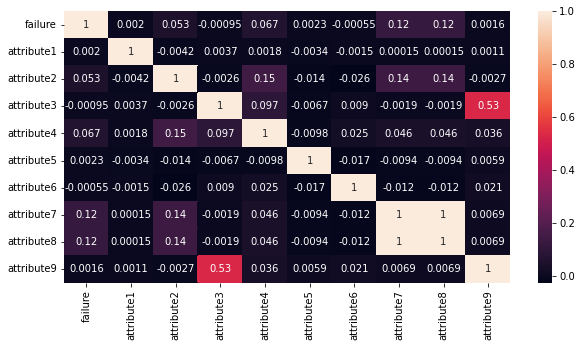

In [116]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True);

In [117]:
# attribute7 ile attribute8 ayni birini sileriz
df.drop(columns='attribute8', inplace=True)

In [118]:
df['failure'].value_counts() # We have imbalanced data

0    124388
1       106
Name: failure, dtype: int64

### 2 defa failure olan cihaz

In [120]:
any(df[df.failure==1].device.value_counts().values>1) # yokmus

False

### Feature Enginnering

In [121]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [122]:
df['ever_fail'] = df.device.map(df.groupby('device')['failure'].max()) # en az 1 defa fail olup olmadigi

In [123]:
df['date']=pd.to_datetime(df['date']) # zaman farki alabilmek icin date i datetime a cevirdik

In [124]:
df['day']=df['date'].dt.day
df['month']=df['date'].dt.month
df['year']=df['date'].dt.year

In [125]:
df['season'] = df.month % 12 // 3 + 1 # month to season
df['season'] = df.season.astype('object')

In [126]:
df['start_date'] = df.device.map(df.groupby('device')['date'].min()) # cihazin baslangic zamani

In [127]:
delta = df.date - df.start_date
df['worked_days'] = delta.dt.days # cihazin calistigi gun sayisi

In [135]:
df['device_type']=[i[:4] for i in df.device.values.tolist()] # cihaz tipi

In [142]:
df['max_day'] = df.device.map(df.groupby('device')['worked_days'].max()) # max calisilan gun

In [145]:
df['last_day'] = df.max_day == df.worked_days # kaydin son gun olup olmadigi

In [146]:
df.sample(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,ever_fail,day,month,year,season,start_date,worked_days,device_type,max_day,last_day
17269,2015-01-21,S1F0PF5Q,0,196755648,0,0,0,12,265333,0,...,0,21,1,2015,1,2015-01-01,20,S1F0,47,False
2155,2015-01-02,Z1F0LCDA,0,42891776,0,0,0,6,195199,40,...,0,2,1,2015,1,2015-01-01,1,Z1F0,4,False
46950,2015-03-04,W1F0WN8P,0,205380520,0,0,0,7,191519,0,...,0,4,3,2015,2,2015-01-01,62,W1F0,85,False
52131,2015-03-12,S1F10BNL,0,597296,0,0,0,14,338421,0,...,0,12,3,2015,2,2015-01-01,70,S1F1,244,False
102602,2015-07-13,Z1F0LKEE,0,220306064,0,0,0,11,485390,0,...,0,13,7,2015,3,2015-01-01,193,Z1F0,284,False


## Her Cihazin Son Kaydinin Alinmasi

In [148]:
df_last = df[df.last_day==True]

In [151]:
df_last.sample(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,ever_fail,day,month,year,season,start_date,worked_days,device_type,max_day,last_day
78335,2015-05-06,S1F136J0,0,194511456,0,0,28,16,343593,0,...,1,6,5,2015,2,2015-01-01,125,S1F1,125,True
112375,2015-08-12,S1F0RVVR,0,150247120,0,0,0,8,189926,0,...,0,12,8,2015,3,2015-01-01,223,S1F0,223,True
5664,2015-01-05,Z1F0LR8G,0,126983536,0,0,0,6,205488,0,...,0,5,1,2015,1,2015-01-01,4,Z1F0,4,True
6689,2015-01-06,Z1F06WA0,0,115355024,0,0,12,9,384248,0,...,0,6,1,2015,1,2015-01-01,5,Z1F0,5,True
107586,2015-07-28,W1F14XGD,1,89738992,15336,0,0,12,242949,0,...,1,28,7,2015,3,2015-01-01,208,W1F1,208,True


Silinecekler:

*date, device, ever_fail, day, month, year, start_date, max_day, last_day

In [152]:
df_last.drop(columns=['date', 'device', 'ever_fail', 'day', 'month', 'year', 'start_date', 'max_day', 'last_day'], inplace=True)

In [153]:
df_last.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,worked_days
count,1168.000000,1.168000e+03,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,0.086473,1.220673e+08,873.006849,31.270548,9.816781,12.442637,270190.081336,4.446918,49.273116,111.567637
std,0.281181,7.035912e+07,5993.391146,738.567698,78.979344,12.371227,104361.153976,43.744396,678.406911,103.990601
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,12.000000,0.000000,0.000000,2.000000
25%,0.000000,5.969821e+07,0.000000,0.000000,0.000000,7.000000,212482.250000,0.000000,0.000000,5.000000
50%,0.000000,1.221506e+08,0.000000,0.000000,0.000000,9.000000,261072.000000,0.000000,0.000000,85.000000
75%,0.000000,1.823452e+08,0.000000,0.000000,0.000000,12.000000,328148.250000,0.000000,1.000000,225.000000
max,1.000000,2.433294e+08,64792.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,18701.000000,305.000000


In [155]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 3051 to 124493
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   failure      1168 non-null   int64 
 1   attribute1   1168 non-null   int64 
 2   attribute2   1168 non-null   int64 
 3   attribute3   1168 non-null   int64 
 4   attribute4   1168 non-null   int64 
 5   attribute5   1168 non-null   int64 
 6   attribute6   1168 non-null   int64 
 7   attribute7   1168 non-null   int64 
 8   attribute9   1168 non-null   int64 
 9   season       1168 non-null   object
 10  worked_days  1168 non-null   int64 
 11  device_type  1168 non-null   object
dtypes: int64(10), object(2)
memory usage: 118.6+ KB


In [154]:
df_last.nunique()

failure           2
attribute1     1167
attribute2      118
attribute3       44
attribute4       67
attribute5       58
attribute6     1134
attribute7       22
attribute9       63
season            4
worked_days     104
device_type       7
dtype: int64

In [156]:
df_last['attribute7'] = df_last['attribute7'].astype('object') # sayi olamayacak kadar az unique degeri var

## Undersampling and Classification (Without data cleaning etc)

In [158]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=4)
x,y = rus.fit_resample(df_last.drop(columns=['failure']), df_last.failure)

In [166]:
x_dummies = pd.get_dummies(x, drop_first=True)

In [167]:
classification_(x_dummies, y) # classification_ function has own train_test_split

,AccuracyScore,PrecisionScore,RecallScore,f1_Score
GradientBoosting,0.951220,1.000000,0.90,0.947368
XGBClassifier,0.926829,0.947368,0.90,0.923077
AdaBoost,0.902439,1.000000,0.80,0.888889
DecisionTree,0.878049,0.941176,0.80,0.864865
RandomForest,0.829268,1.000000,0.65,0.787879
Bernoulli,0.780488,0.866667,0.65,0.742857
SVC,0.560976,0.545455,0.60,0.571429
MultinominalNB,0.609756,0.642857,0.45,0.529412
KNeighbors,0.585366,0.600000,0.45,0.514286
LogisticReg,0.658537,0.875000,0.35,0.500000


## Deep Learning

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x_dummies, y, test_size=.2, random_state=4)

In [171]:
import tensorflow as tf
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.50),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(512, activation='softmax'),])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test,y_test))

Epoch 1/40
2/2 [==============================] - 3s 190ms/step - loss: 10287763.0000 - accuracy: 0.0994 - val_loss: 1713700.1250 - val_accuracy: 0.4634
Epoch 2/40
2/2 [==============================] - 0s 24ms/step - loss: 1616982.6250 - accuracy: 0.4907 - val_loss: 578741.7500 - val_accuracy: 0.4634
Epoch 3/40
2/2 [==============================] - 0s 23ms/step - loss: 913165.9375 - accuracy: 0.5652 - val_loss: 168920.2656 - val_accuracy: 0.5366
Epoch 4/40
2/2 [==============================] - 0s 24ms/step - loss: 1119431.5000 - accuracy: 0.4783 - val_loss: 726195.1875 - val_accuracy: 0.4634
Epoch 5/40
2/2 [==============================] - 0s 41ms/step - loss: 1560567.6250 - accuracy: 0.4348 - val_loss: 928288.1250 - val_accuracy: 0.4634
Epoch 6/40
2/2 [==============================] - 0s 23ms/step - loss: 1052035.3750 - accuracy: 0.4845 - val_loss: 927691.6250 - val_accuracy: 0.5366
Epoch 7/40
2/2 [==============================] - 0s 24ms/step - loss: 1612551.8750 - accuracy: 0.

In [172]:
_, accuracy=model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100)) # Accuracy dusuk cunku kullandigimiz data az

2/2 [==============================] - 0s 10ms/step - loss: 5459.5015 - accuracy: 0.5366
Accuracy: 53.66
